In [1]:
# get access to the complete repo
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(),"..",".."))
main_copy_dir = os.path.join(parent_dir, "main_copy")
octagon_analysis = os.path.join(parent_dir, "octagon_analysis")
sys.path.append(main_copy_dir)
sys.path.append(octagon_analysis)

print("Added paths to sys.path", main_copy_dir, octagon_analysis)

Added paths to sys.path /Users/benny/Desktop/MSc/Project/Git/repos/main_copy /Users/benny/Desktop/MSc/Project/Git/repos/octagon_analysis


In [ ]:
# imports
%load_ext autoreload
%autoreload 2

import parse_data.prepare_data as prepare_data
import analysis.opponent_visibility as opponent_visibility
import trajectory_analysis.trajectory_vectors as trajectory_vectors
import trajectory_analysis.trajectory_headangle as trajectory_headangle
import data_extraction.trial_list_filters as trial_list_filters
from plotting import plot_octagon, plot_trajectory
import utils.cosine_similarity as cosine_similarity
import data_extraction.extract_trial as extract_trial
import parse_data.identify_filepaths as identify_filepaths
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import globals



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# data folder and filenames
data_folder = "/Users/benny/Desktop/MSc/Project/Git/repos/main_copy/questionnaire_analysis/pseudonymised_json_files"

social_files, ordered_solos = identify_filepaths.get_filenames(data_folder=data_folder)

In [6]:
# single json filename

json_filename = social_files[17]

In [7]:
_, trial_list = prepare_data.prepare_data(data_folder, json_filename, combine=True)

filepath: /Users/benny/Desktop/MSc/Project/Git/repos/main_copy/questionnaire_analysis/pseudonymised_json_files/241203_1/2024-12-03_14-31-51_PO03_NN03_Social.json
Loading complete.
Preprocessing complete.


In [159]:
# global variables
player_id = 0
other_id = 1
trial_num = 16
trial = trial_list[trial_num]
fov = 110

In [160]:
# gather data for head angle and vector to opponent

player_position_coordinates = opponent_visibility.get_player_position_slice_onset(player_id, trial)
other_position_coordinates = opponent_visibility.get_player_position_slice_onset(other_id, trial)

trajectory = trajectory_vectors.extract_trial_player_trajectory(trial=trial, player_id=player_id)
other_trajectory = trajectory_vectors.extract_trial_player_trajectory(trial=trial, player_id=other_id)

headangles = trajectory_vectors.extract_trial_player_headangles(trial=trial, player_id=player_id)
trial_player_headangles =  trajectory_headangle.get_player_headangle_vectors_for_trial(headangles)
trial_player_headangles_smoothed = trajectory_headangle.get_smoothed_player_head_angle_vectors_for_trial(headangles, window_size=5)

headangles_other = trajectory_vectors.extract_trial_player_headangles(trial=trial, player_id=other_id)
trial_player_headangles_other =  trajectory_headangle.get_player_headangle_vectors_for_trial(headangles)
trial_player_headangles_smoothed_other = trajectory_headangle.get_smoothed_player_head_angle_vectors_for_trial(headangles, window_size=5)

self_other_vector = other_position_coordinates - player_position_coordinates

# I don't think I'm using these
head_angle_vector = opponent_visibility.get_player_headangle_vector_slice_onset(player_id, trial)
head_angle_vector_other = opponent_visibility.get_player_headangle_vector_slice_onset(other_id, trial)

In [161]:
# get output from other visibility functions

# compare to plotted thetas
# print out at the bottom in matrix form reflecting arrangement of plots
# each matrix (of 2) will contain angles between head angle vector and self to other vector for the two players
angle_to_opponent_player = opponent_visibility.get_angle_of_opponent_from_player_trial(player_id, trial)
angle_to_opponent_other = opponent_visibility.get_angle_of_opponent_from_player_trial(other_id, trial)

# compare to plotted vectors 
# print out at the bottom in matrix form reflecting arrangement of plots
# each matrix (of 2) will be a binary output for opponent visible (1) or not visible (0)
orientation_angle_to_other_session = opponent_visibility.get_angle_of_opponent_from_player_session(player_id, trial_list)
orientation_angle_to_player_session = opponent_visibility.get_angle_of_opponent_from_player_session(other_id, trial_list)
other_visible_session = opponent_visibility.get_other_visible_session(orientation_angle_to_other_session, fov)
player_visible_session = opponent_visibility.get_other_visible_session(orientation_angle_to_player_session, fov)

# trial list filters
(_, other_visible_trial_indices) = trial_list_filters.filter_trials_other_visible(trial_list, other_visible_session, inverse=False)

(_, other_not_visible_trial_indices) = trial_list_filters.filter_trials_other_visible(trial_list, other_visible_session, inverse=True)

(_, player_visible_trial_indices) = trial_list_filters.filter_trials_other_visible(trial_list, player_visible_session, inverse=False)

(_, player_not_visible_trial_indices) = trial_list_filters.filter_trials_other_visible(trial_list, player_visible_session, inverse=True)

In [186]:
# get visualisation vector coordinates
def get_other_visible_vectors(player_position_coordinates, other_position_coordinates, trial_player_headangles_smoothed, trial_player_headangles_smoothed_other, vector_length = 20, start_index = 0):
    ''' Return coordinates of vectors from player location to head angle direction 
    and from player to opponent'''

    # get player position coordinates at slice onset
    x_coordinate = player_position_coordinates[0,start_index]
    y_coordinate = player_position_coordinates[1,start_index]

    x_other_coordinate = other_position_coordinates[0,start_index]
    y_other_coordinate = other_position_coordinates[1,start_index]

    # get player head angle coordinates for smoothed head angles
    x_headangle = trial_player_headangles_smoothed[0,start_index]
    y_headangle = trial_player_headangles_smoothed[1,start_index]

    x_other_headangle = trial_player_headangles_smoothed_other[0,start_index]
    y_other_headangle = trial_player_headangles_smoothed_other[1,start_index]

    # get vector between players 
    player_position_flat = player_position_coordinates.flatten()
    other_position_flat = other_position_coordinates.flatten()

    self_other_vector = other_position_flat - player_position_flat
    other_self_vector = - self_other_vector
    self_other_vector_scaled = (self_other_vector/np.linalg.norm(self_other_vector)) * vector_length
    other_self_vector_scaled = - self_other_vector_scaled

    # assign start and end coordinates
    start = [x_coordinate, y_coordinate]
    other_start = [x_other_coordinate, y_other_coordinate]

    end = [x_coordinate + x_headangle * vector_length, y_coordinate + y_headangle * vector_length]
    other_end = [x_other_coordinate + x_other_headangle * vector_length, y_other_coordinate + y_other_headangle * vector_length]

    head_direction_vector_coordinates = np.array(list(zip(start,end)))
    head_direction_vector_coordinates_other = np.array(list(zip(other_start,other_end)))

    return(head_direction_vector_coordinates, head_direction_vector_coordinates_other,
           self_other_vector_scaled, other_self_vector_scaled,
           player_position_coordinates, other_position_coordinates)



In [187]:
(head_direction_vector_coordinates, head_direction_vector_coordinates_other,
self_other_vector_scaled, other_self_vector_scaled,
player_position_coordinates, other_position_coordinates) = get_other_visible_vectors(player_position_coordinates, other_position_coordinates, trial_player_headangles_smoothed, trial_player_headangles_smoothed_other, vector_length = 20, start_index = 0)


In [188]:
head_direction_vector_coordinates_other

array([[-0.33504552,  5.55686815],
       [-0.59759122, 18.50593938]])

In [189]:
head_direction_vector_coordinates

array([[ -4.20293093, -17.59307542],
       [ -0.30189323, -15.15728537]])

In [167]:
def get_other_visibility_testing_information(player_id, other_id, trial=None, trial_list=None, trial_num=None):
    '''Returns all data required to plot other visibility vectors, head angle vector, and angles
    for get_other_visible_vectors and plot_other_visibility_vectors'''

    trial = extract_trial.extract_trial(trial=trial, trial_list=trial_list, trial_index=trial_num)

    player_position_coordinates = opponent_visibility.get_player_position_slice_onset(player_id, trial)
    other_position_coordinates = opponent_visibility.get_player_position_slice_onset(other_id, trial)

    trajectory = trajectory_vectors.extract_trial_player_trajectory(trial=trial, player_id=player_id)
    other_trajectory = trajectory_vectors.extract_trial_player_trajectory(trial=trial, player_id=other_id)

    headangles = trajectory_vectors.extract_trial_player_headangles(trial=trial, player_id=player_id)
    trial_player_headangles =  trajectory_headangle.get_player_headangle_vectors_for_trial(headangles)
    trial_player_headangles_smoothed = trajectory_headangle.get_smoothed_player_head_angle_vectors_for_trial(headangles, window_size=5)

    headangles_other = trajectory_vectors.extract_trial_player_headangles(trial=trial, player_id=other_id)
    trial_player_headangles_other =  trajectory_headangle.get_player_headangle_vectors_for_trial(headangles_other)
    trial_player_headangles_smoothed_other = trajectory_headangle.get_smoothed_player_head_angle_vectors_for_trial(headangles_other, window_size=5)

    #self_other_vector = other_position_coordinates - player_position_coordinates

    player_theta = opponent_visibility.get_angle_of_opponent_from_player_trial(player_id, trial)
    other_theta = opponent_visibility.get_angle_of_opponent_from_player_trial(other_id, trial)


    return(player_position_coordinates, other_position_coordinates,
           trajectory, other_trajectory, 
           trial_player_headangles, trial_player_headangles_other, 
           trial_player_headangles_smoothed, trial_player_headangles_smoothed_other,
           player_theta, other_theta)



In [190]:
(player_position_coordinates, other_position_coordinates,
trajectory, other_trajectory, 
trial_player_headangles, trial_player_headangles_other, 
trial_player_headangles_smoothed, trial_player_headangles_smoothed_other,
player_theta, other_theta) = get_other_visibility_testing_information(player_id, other_id, trial=None, trial_list=trial_list, trial_num=trial_num)


In [191]:
def get_self_to_other_vectors_for_trajectory(trajectory, trajectory_other, player_id, other_id):
    '''Calculate the direction vector between one player and the other'''

    timepoints = trajectory.shape[1]
    timepoints_other = trajectory_other.shape[1]
    vectors_to_other = np.zeros((2,timepoints))
    vectors_to_player = np.zeros((2,timepoints_other))

    for time_index in range(0, trajectory.shape[1]):
        player_x_coordinate = trajectory[0,time_index]
        player_y_coordinate = trajectory[1,time_index]

        other_x_coordinate = trajectory_other[0,time_index]
        other_y_coordinate = trajectory_other[1,time_index]

        vector_to_other = trajectory_other[:,time_index] - trajectory[:,time_index]
        vector_to_player = trajectory[:,time_index] - trajectory_other[:,time_index]

        vectors_to_other[:,time_index] = vector_to_other
        vectors_to_player[:,time_index] = vector_to_player

    return(vectors_to_other, vectors_to_player)

In [192]:
(vectors_to_other, vectors_to_player) = get_self_to_other_vectors_for_trajectory(trajectory, other_trajectory, player_id, other_id)


In [193]:
def get_thetas_to_opponent_for_trial(vector_to_other, vector_to_player, trial_player_headangles, trial_player_headangles_other, trajectory):

    timepoints = trajectory.shape[1]
    thetas_player = np.zeros([1,timepoints])
    thetas_other = np.zeros([1,timepoints])

    for time_index in range(0, timepoints):

        dot_product_vectors_player = np.dot(vector_to_other[:,time_index].flatten(), trial_player_headangles[:,time_index].flatten())
        dot_product_vectors_other = np.dot(vector_to_player[:,time_index].flatten(), trial_player_headangles_other[:,time_index].flatten())

        (player_other_vector_norm,
         player_head_angle_vector_norm) = opponent_visibility.calculate_vector_norms_for_timepoint(vector_to_other[:,time_index],
                                                                                                   trial_player_headangles[:,time_index])
        
        (other_player_vector_norm,
         other_head_angle_vector_norm) = opponent_visibility.calculate_vector_norms_for_timepoint(vector_to_player[:,time_index],
                                                                                                   trial_player_headangles_other[:,time_index])
        
        vector_cosine_similarity_player = cosine_similarity.calculate_cosine_similarity_two_vectors(dot_product_vectors_player,
                                                                                                    player_other_vector_norm,
                                                                                                    player_head_angle_vector_norm)
        vector_cosine_similarity_other = cosine_similarity.calculate_cosine_similarity_two_vectors(dot_product_vectors_other,
                                                                                                    other_player_vector_norm,
                                                                                                    other_head_angle_vector_norm)

        thetas_player[:,time_index] = cosine_similarity.calculate_angle_from_cosine_similarity(vector_cosine_similarity_player)
        thetas_other[:,time_index] = cosine_similarity.calculate_angle_from_cosine_similarity(vector_cosine_similarity_other)

    return(thetas_player, thetas_other)

In [194]:
thetas_player, thetas_other = get_thetas_to_opponent_for_trial(vectors_to_other, vectors_to_player, trial_player_headangles, trial_player_headangles_other, trajectory)


In [230]:
head_direction_vector_coordinates[:,1]

array([-17.59307542, -15.15728537])

In [246]:
np.rad2deg(3.4)

np.float64(194.8056503444799)

In [318]:
def plot_other_visibility_vectors(head_direction_vector_coordinates, head_direction_vector_coordinates_other,
                                  player_position_coordinates, other_position_coordinates, trajectory, trajectory_other,
                                  self_other_vector_scaled, other_self_vector_scaled,
                                  radius = 2, start_index = 0, colours = ['r', 'b', 'g','orange','purple'], axes=None):
    '''Return octagon plot with four vectors and two angles: head direction vector for player 0, 
    head direction vector for player 1, overlapping arrow vectors from one player to another,
    angles between player head direction vector and self-other vector'''

    # plot the octagon
    ax = plot_octagon.plot_octagon(ax=axes)

    # plot trajectories
    ax.scatter(trajectory[0, :], trajectory[1, :], s=0.5)
    ax.scatter(trajectory_other[0, :], trajectory_other[1, :], s=0.5)

    # NOTE: potentially add prior logic for plotting loser trajectory in blue and winner trajectory in red

    # plot head angle vectors
    ax.plot(head_direction_vector_coordinates[0,:], head_direction_vector_coordinates[1,:], c=colours[1], linewidth=2)
    ax.plot(head_direction_vector_coordinates_other[0,:], head_direction_vector_coordinates_other[1,:], c=colours[3], linewidth=2)

    # plot vector between players
    x_coordinate = player_position_coordinates[0,start_index]
    y_coordinate = player_position_coordinates[1,start_index]

    #ax.plot(x_coordinate, y_coordinate, 'bo')

    x_other = other_position_coordinates[0,start_index]
    y_other = other_position_coordinates[1,start_index]

    #ax.plot(x_other, y_other, 'bo')

    ax.quiver(x_coordinate, y_coordinate,
              self_other_vector_scaled[0], self_other_vector_scaled[1],
              angles='xy', scale_units='xy', scale=0.05, color=colours[4])

    ax.quiver(x_other, y_other,
              other_self_vector_scaled[0], other_self_vector_scaled[1],
              angles='xy', scale_units='xy', scale=0.05, color=colours[4])



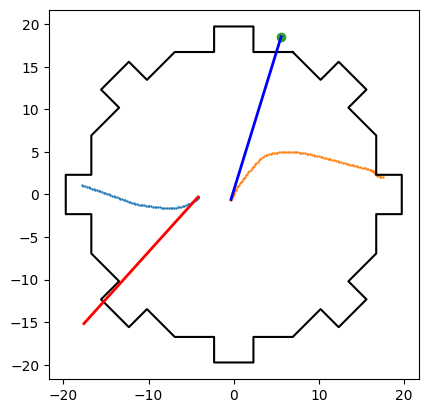

In [197]:
ax = plot_octagon.plot_octagon(ax=None)

ax.scatter(trajectory[0, :], trajectory[1, :], s=0.5)
ax.scatter(other_trajectory[0, :], other_trajectory[1, :], s=0.5)

ax.scatter(head_direction_vector_coordinates_other[0,1], head_direction_vector_coordinates_other[1,1])
colours = ['r', 'b', 'g','orange']

ax.plot(head_direction_vector_coordinates[0,:], head_direction_vector_coordinates[1,:], c=colours[0], linewidth=2)
ax.plot(head_direction_vector_coordinates_other[0,:], head_direction_vector_coordinates_other[1,:], c=colours[1], linewidth=2)


In [ ]:

def plot_single_trial_other_visibility(trial_list, trial_num, player_id, other_id):
    '''Single plot showing player head direction vectors, self to other vectors, angles between them and trajectories'''

    fig, ax = plt.subplots()

    # get all relevant information for trial other visibility
    (player_position_coordinates, other_position_coordinates,
    trajectory, other_trajectory, 
    trial_player_headangles, trial_player_headangles_other, 
    trial_player_headangles_smoothed, trial_player_headangles_smoothed_other,
    player_theta, other_theta) = get_other_visibility_testing_information(player_id, other_id, trial_list=trial_list, trial_num=trial_num)
    
    # get visualisation vector coordinates
    (head_direction_vector_coordinates, head_direction_vector_coordinates_other,
           self_other_vector_scaled, other_self_vector_scaled,
           player_position_coordinates, other_position_coordinates) = get_other_visible_vectors(player_position_coordinates, other_position_coordinates, 
                                                                                                trial_player_headangles_smoothed, trial_player_headangles_smoothed_other, vector_length = 20, start_index = 0)
    
    # get angle between player head angle vector and vector to opponent for the entire trajectory
    (vector_to_other, vector_to_player) = get_self_to_other_vectors_for_trajectory(trajectory, other_trajectory, player_id, other_id)
    (thetas_player, thetas_other) = get_thetas_to_opponent_for_trial(vector_to_other, vector_to_player, trial_player_headangles, trial_player_headangles_other, trajectory)

    ax = plot_other_visibility_vectors(head_direction_vector_coordinates, head_direction_vector_coordinates_other,
                                        player_position_coordinates, other_position_coordinates, trajectory, other_trajectory,
                                        self_other_vector_scaled, other_self_vector_scaled,
                                        radius = 2.5, start_index = 0, colours = ['r', 'b', 'g','orange','purple'], axes=ax)

    plt.show()
    
    thetas_player = thetas_player
    thetas_other = thetas_other

    return (thetas_player, thetas_other)



0.6011140732542017
34.44129940338356


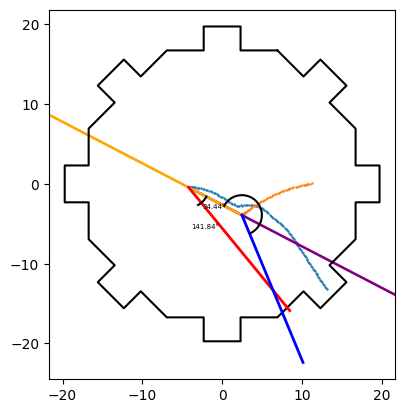

In [306]:
(thetas_player, thetas_other) = plot_single_trial_other_visibility(trial_list=trial_list, trial_num=trial_num, player_id=player_id, other_id=other_id)


In [286]:
rows=5
cols=5
trial_num_offset=0

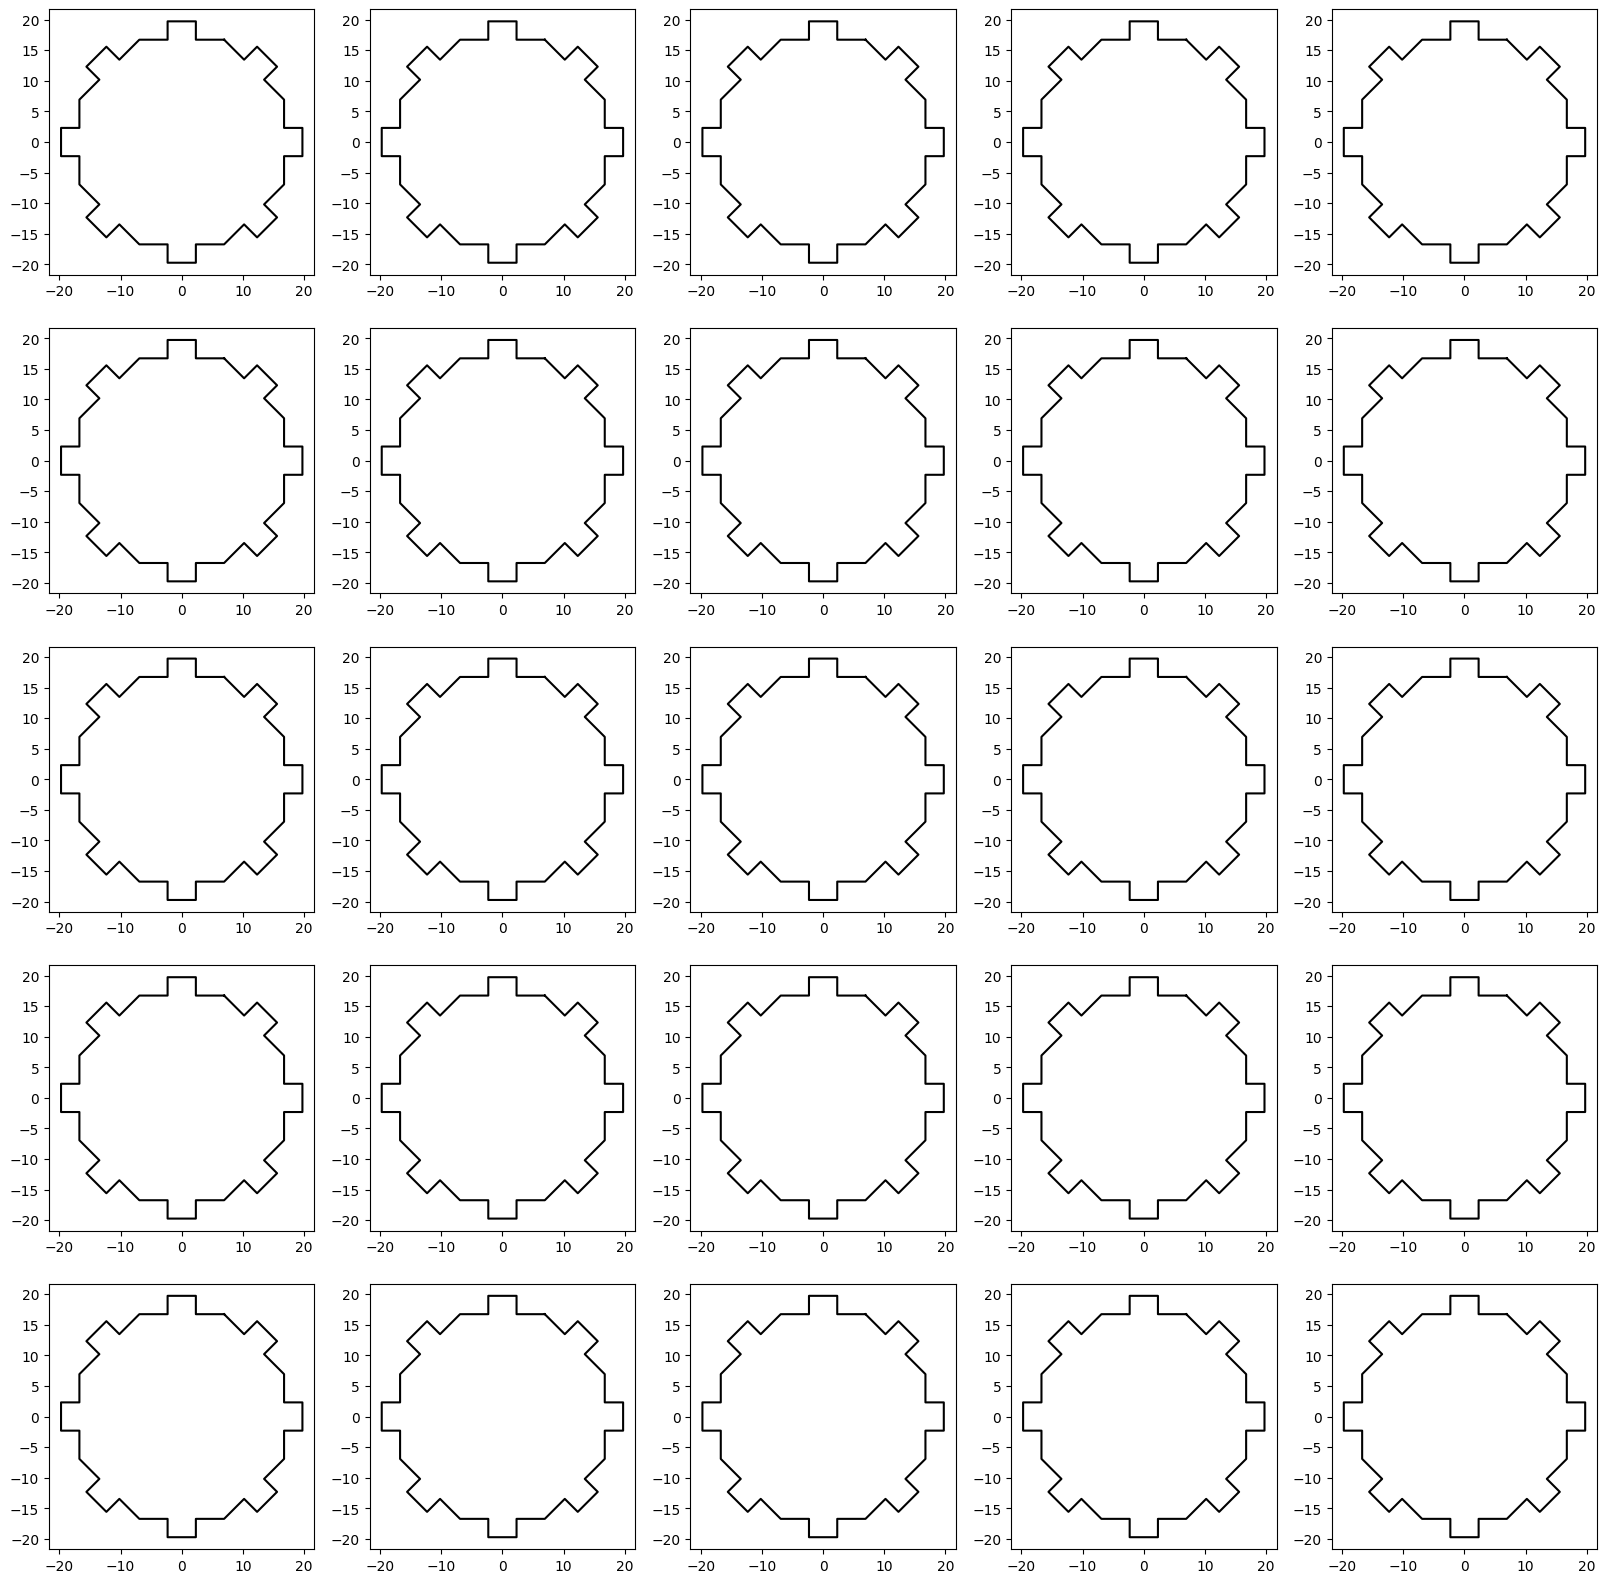

In [298]:
fig, axes = plt.subplots(rows,cols,figsize=(20,20))
for i in range(rows):
    for j in range(cols):
        trial_num = i*rows + j + trial_num_offset
        #print(trial_num)

        (player_position_coordinates, other_position_coordinates,
        trajectory, other_trajectory, 
        trial_player_headangles, trial_player_headangles_other, 
        trial_player_headangles_smoothed, trial_player_headangles_smoothed_other,
        player_theta, other_theta) = get_other_visibility_testing_information(player_id, other_id, trial_list=trial_list, trial_num=trial_num)

        (head_direction_vector_coordinates, head_direction_vector_coordinates_other,
            self_other_vector_scaled, other_self_vector_scaled,
            player_position_coordinates, other_position_coordinates) = get_other_visible_vectors(player_position_coordinates, other_position_coordinates, 
                                                                                        trial_player_headangles_smoothed, trial_player_headangles_smoothed_other, vector_length = 20, start_index = 0)
        #print(self_other_vector_scaled,other_self_vector_scaled)
        # get angle between player head angle vector and vector to opponent for the entire trajectory
        (vector_to_other, vector_to_player) = get_self_to_other_vectors_for_trajectory(trajectory, other_trajectory, player_id, other_id)
        # (thetas_player, thetas_other) = get_thetas_to_opponent_for_trial(vector_to_other, vector_to_player, trial_player_headangles, trial_player_headangles_other, trajectory)
        # print(vector_to_other, vector_to_player)
        axes[i,j] = plot_octagon.plot_octagon(ax=axes[i,j])


In [308]:
def plot_multiple_trials_other_visibility(rows, cols, player_id, other_id, trial_list, trial_num_offset=0, start_index=0):
    ''' Subplots showing player head direction vectors, self to other vectors, angles between them and trajectories'''

    fig, axes = plt.subplots(rows,cols,figsize=(20,20))

    player_thetas = np.full((rows,cols), np.nan, dtype=float)
    other_thetas = np.full((rows,cols), np.nan, dtype=float)

    for i in range(rows):
        for j in range(cols):
            trial_num = i*rows + j + trial_num_offset

            try:
                # get all relevant information for trial other visibility
                (player_position_coordinates, other_position_coordinates,
                trajectory, other_trajectory, 
                trial_player_headangles, trial_player_headangles_other, 
                trial_player_headangles_smoothed, trial_player_headangles_smoothed_other,
                player_theta, other_theta) = get_other_visibility_testing_information(player_id, other_id, trial_list=trial_list, trial_num=trial_num)
                
                # get visualisation vector coordinates
                (head_direction_vector_coordinates, head_direction_vector_coordinates_other,
                    self_other_vector_scaled, other_self_vector_scaled,
                    player_position_coordinates, other_position_coordinates) = get_other_visible_vectors(player_position_coordinates, other_position_coordinates, 
                                                                                                trial_player_headangles_smoothed, trial_player_headangles_smoothed_other, vector_length = 20, start_index = 0)

                # get angle between player head angle vector and vector to opponent for the entire trajectory
                (vector_to_other, vector_to_player) = get_self_to_other_vectors_for_trajectory(trajectory, other_trajectory, player_id, other_id)
                # (thetas_player, thetas_other) = get_thetas_to_opponent_for_trial(vector_to_other, vector_to_player, trial_player_headangles, trial_player_headangles_other, trajectory)
            
            except Exception as e:
                axes[i,j].axis('off')
                continue

            axes[i,j] = plot_other_visibility_vectors(head_direction_vector_coordinates, head_direction_vector_coordinates_other,
                                        player_position_coordinates, other_position_coordinates, trajectory, other_trajectory,
                                        self_other_vector_scaled, other_self_vector_scaled,
                                        radius = 2, start_index = 0, colours = ['r', 'b', 'g','orange','purple'], axes=axes[i,j])
            
            #player_theta[i,j] = round(player_theta[:,start_index], 1)
            #other_theta[i,j] = round(other_theta[:,start_index], 1)

    plt.tight_layout()

    plt.show()

            #return (player_theta, other_theta)


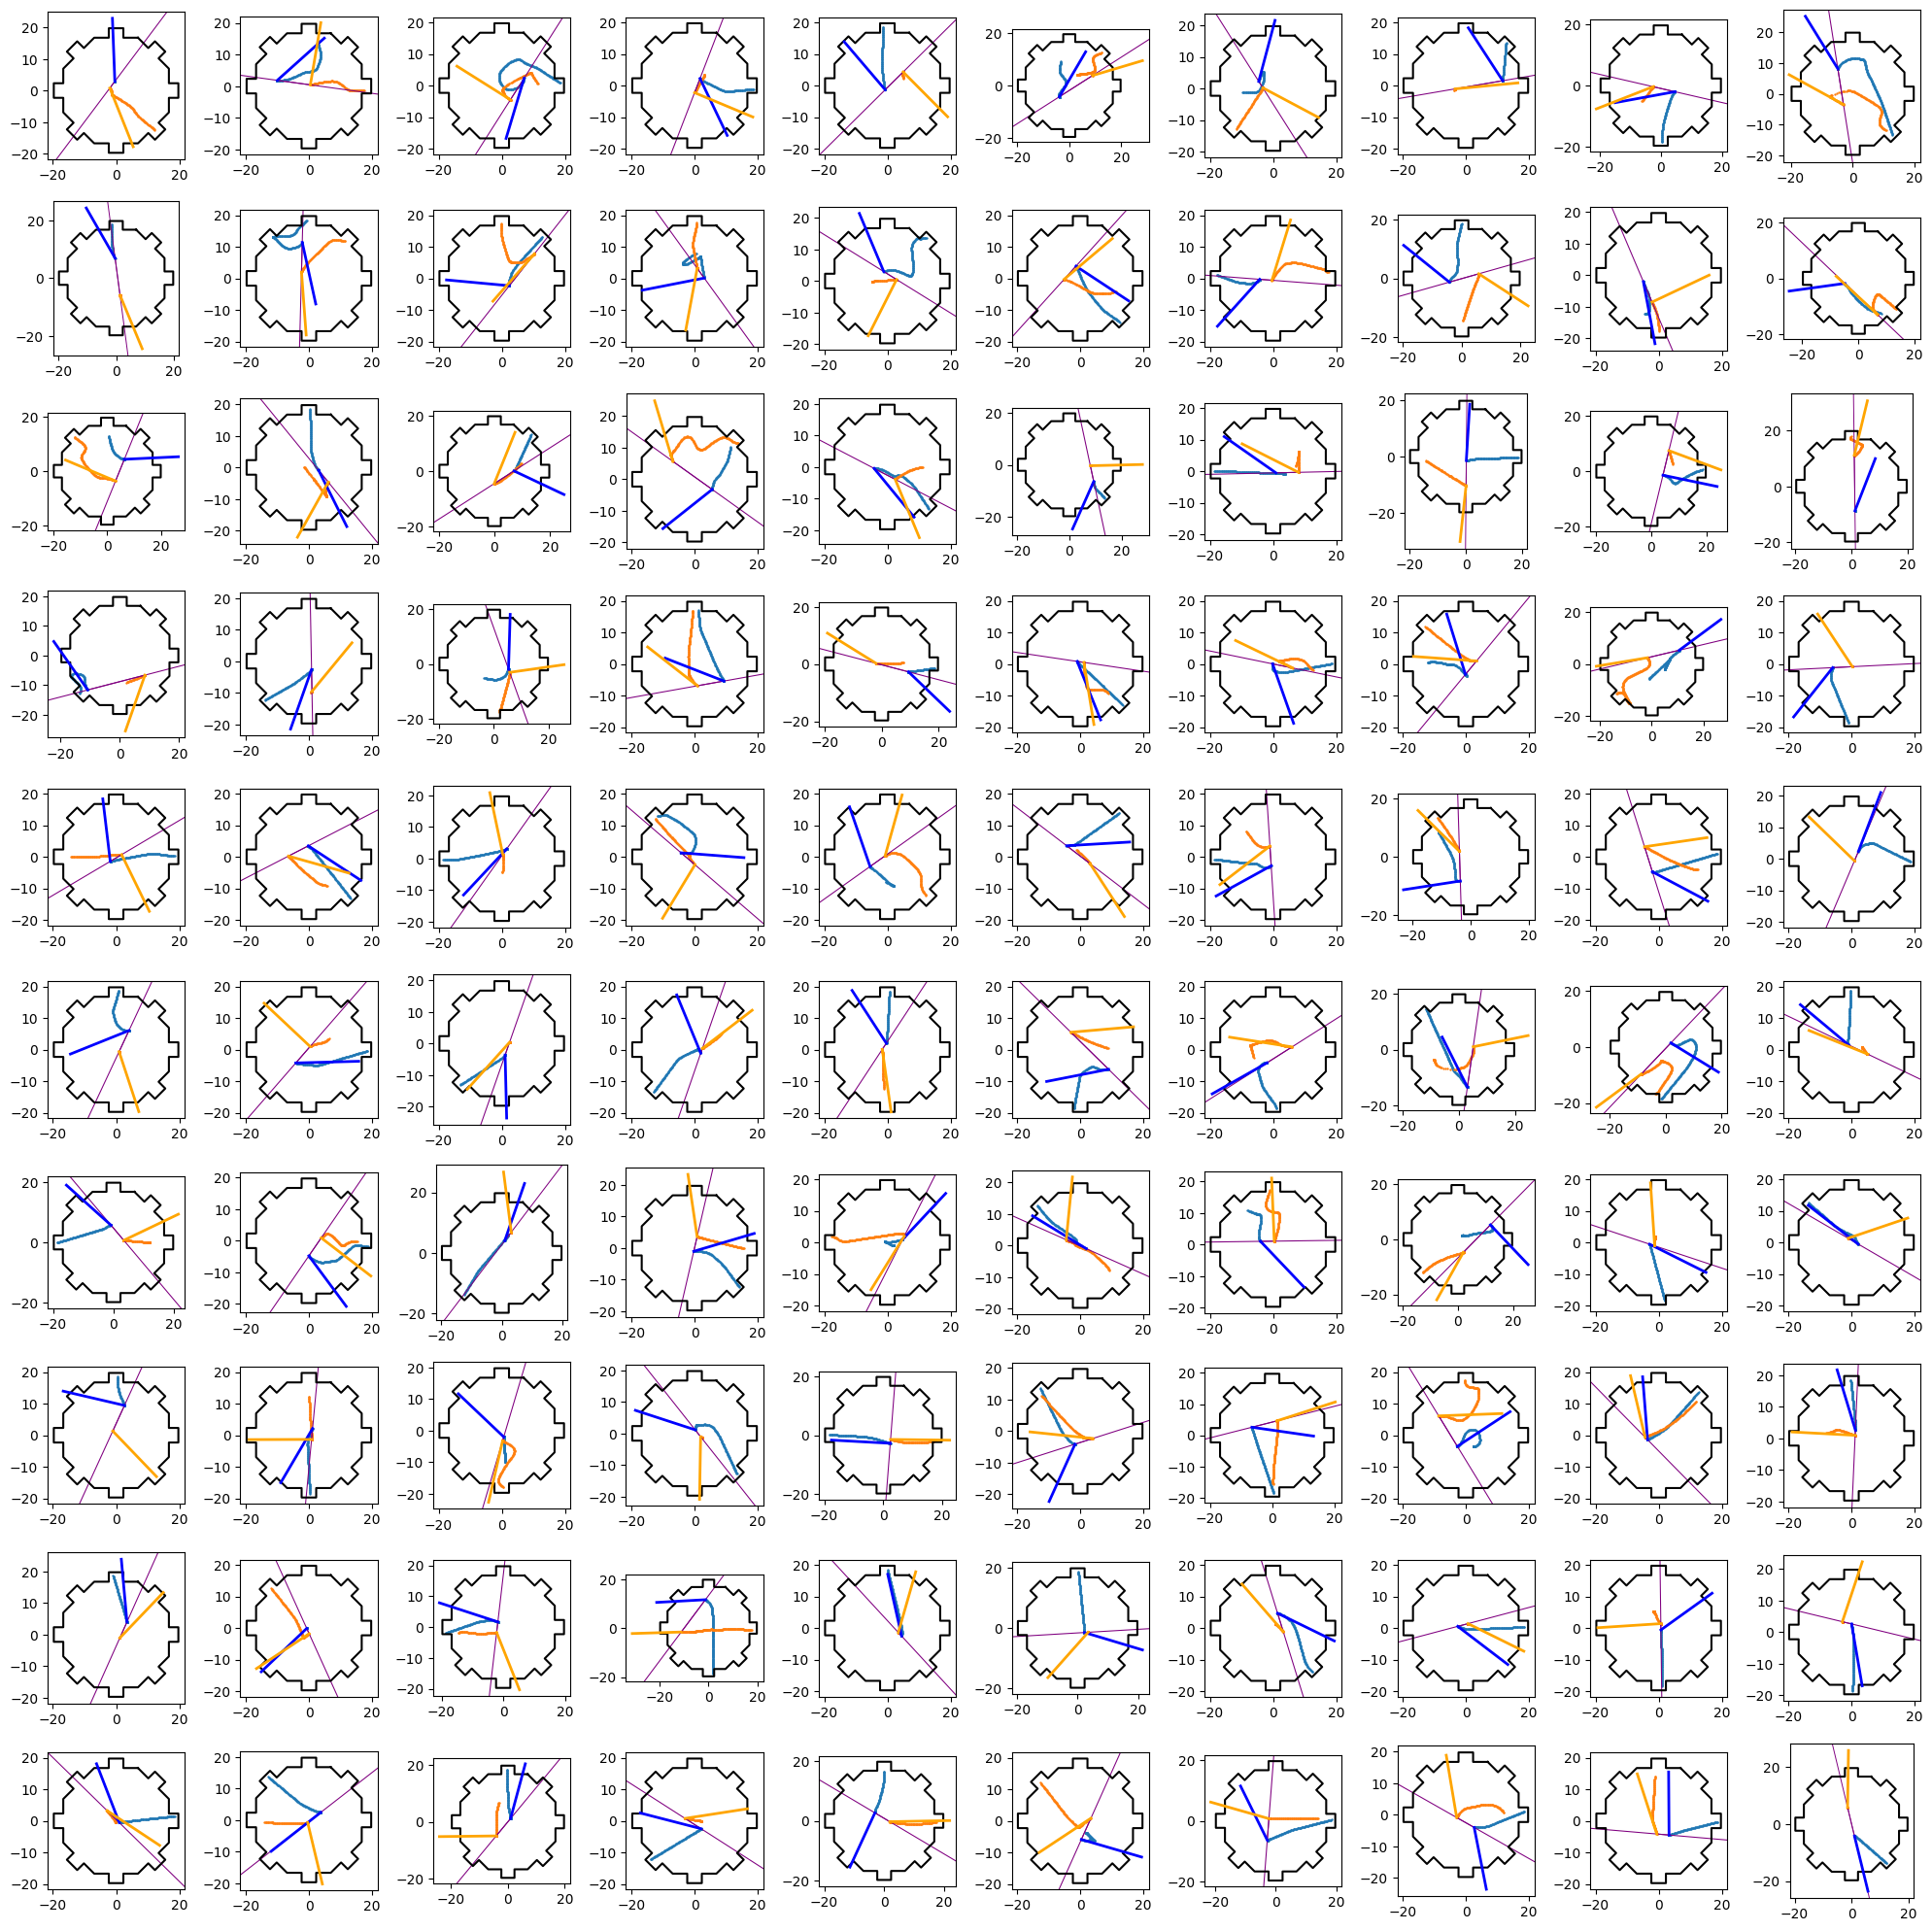

In [320]:
plot_multiple_trials_other_visibility(10, 10, player_id, other_id, trial_list, trial_num_offset=0, start_index=0)

In [336]:
# create two 10x10 empty arrays (or initialize with np.nan if values are optional/missing)
angles_player = np.zeros((11, 11))
angles_other = np.zeros((11, 11))

for trial_index in range(len(trial_list)):
    trial = extract_trial.extract_trial(trial=None, trial_list=trial_list, trial_index=trial_index)
    
    angle_to_opponent_player = opponent_visibility.get_angle_of_opponent_from_player_trial(player_id, trial)
    angle_to_opponent_other = opponent_visibility.get_angle_of_opponent_from_player_trial(other_id, trial)
    
    angle_to_opponent_player = np.rad2deg(angle_to_opponent_player)
    angle_to_opponent_other = np.rad2deg(angle_to_opponent_other)

    row = trial_index // 10
    print(trial_index, row)
    col = trial_index % 10

    angles_player[row, col] = angle_to_opponent_player
    angles_other[row, col] = angle_to_opponent_other   

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 1
11 1
12 1
13 1
14 1
15 1
16 1
17 1
18 1
19 1
20 2
21 2
22 2
23 2
24 2
25 2
26 2
27 2
28 2
29 2
30 3
31 3
32 3
33 3
34 3
35 3
36 3
37 3
38 3
39 3
40 4
41 4
42 4
43 4
44 4
45 4
46 4
47 4
48 4
49 4
50 5
51 5
52 5
53 5
54 5
55 5
56 5
57 5
58 5
59 5
60 6
61 6
62 6
63 6
64 6
65 6
66 6
67 6
68 6
69 6
70 7
71 7
72 7
73 7
74 7
75 7
76 7
77 7
78 7
79 7
80 8
81 8
82 8
83 8
84 8
85 8
86 8
87 8
88 8
89 8
90 9
91 9
92 9
93 9
94 9
95 9
96 9
97 9
98 9
99 9
100 10


In [373]:
angle_to_opponent_player_session_raw = opponent_visibility.get_angle_of_opponent_from_player_session(player_id, trial_list)
angle_to_opponent_player_session = np.round(angle_to_opponent_player_session_raw, 2)
angle_to_opponent_player_session = np.append(angle_to_opponent_player_session, [np.nan] * (110 - len(angle_to_opponent_player_session)))
angle_to_opponent_player_session = angle_to_opponent_player_session.reshape((11,10))

angle_to_opponent_other_session_raw = opponent_visibility.get_angle_of_opponent_from_player_session(other_id, trial_list)
angle_to_opponent_other_session = np.round(angle_to_opponent_other_session_raw, 2)
angle_to_opponent_other_session = np.append(angle_to_opponent_other_session, [np.nan] * (110 - len(angle_to_opponent_other_session)))
angle_to_opponent_other_session = angle_to_opponent_other_session.reshape((11,10))

In [370]:
angle_to_opponent_player_session

array([[2.46, 0.87, 0.41, 0.75, 1.5 , 0.49, 2.33, 1.1 , 0.49, 2.65],
       [2.7 , 0.31, 2.21, 1.14, 2.59, 1.67, 2.23, 2.29, 0.22, 2.24],
       [2.09, 0.13, 1.96, 1.21, 0.33, 2.59, 2.51, 3.12, 1.42, 0.38],
       [2.03, 0.36, 2.89, 0.48, 2.54, 0.96, 0.96, 0.99, 2.88, 2.42],
       [1.26, 2.17, 0.08, 0.56, 1.27, 0.7 , 2.16, 1.86, 2.23, 3.  ],
       [0.69, 0.74, 2.72, 0.64, 1.88, 1.03, 3.12, 0.56, 1.69, 2.96],
       [2.86, 1.78, 0.37, 0.99, 0.22, 0.2 , 0.82, 1.66, 0.07, 0.05],
       [1.28, 0.56, 1.89, 2.42, 1.68, 2.2 , 0.36, 1.54, 0.64, 2.71],
       [2.55, 1.13, 1.69, 0.75, 0.52, 0.36, 0.82, 0.8 , 0.88, 2.12],
       [0.36, 0.07, 2.6 , 0.2 , 1.39, 1.59, 0.61, 2.18, 1.42, 3.07],
       [0.6 ,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan]])

In [372]:
angle_to_opponent_other_session

array([[2.12, 1.52, 1.58, 1.59, 1.57, 2.87, 2.6 , 0.  , 2.51, 0.92],
       [2.85, 3.  , 0.  , 0.68, 1.74, 0.13, 1.76, 2.32, 1.5 , 0.01],
       [1.56, 1.94, 0.75, 2.48, 2.47, 1.41, 0.47, 3.13, 1.47, 2.92],
       [1.07, 0.61, 1.68, 2.34, 2.87, 1.99, 0.24, 0.95, 3.07, 0.95],
       [1.52, 0.66, 0.89, 1.89, 2.43, 2.86, 0.96, 2.36, 1.46, 1.25],
       [2.38, 1.61, 0.37, 2.68, 2.41, 0.99, 0.72, 1.97, 3.02, 0.06],
       [1.81, 1.7 , 2.37, 2.67, 0.04, 1.94, 1.53, 2.65, 1.18, 0.94],
       [1.94, 1.84, 2.99, 2.63, 1.66, 0.41, 2.93, 1.07, 2.62, 1.58],
       [0.24, 1.73, 2.64, 2.24, 2.12, 0.8 , 0.42, 2.63, 1.47, 1.48],
       [0.21, 1.97, 2.37, 0.74, 2.54, 0.31, 1.76, 2.28, 1.97, 2.89],
       [0.67,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan]])

In [388]:
other_visible_session_raw = opponent_visibility.get_other_visible_session(angle_to_opponent_player_session_raw, fov)
player_visible_session_raw = opponent_visibility.get_other_visible_session(angle_to_opponent_other_session_raw, fov)


In [389]:
other_visible_session = other_visible_session_raw.astype(int)
other_visible_session = np.append(other_visible_session, [np.nan] * (110 - len(other_visible_session)))
other_visible_session = other_visible_session.reshape((10,11))

player_visible_session = player_visible_session_raw.astype(int)
player_visible_session = np.append(player_visible_session, [np.nan] * (110 - len(player_visible_session)))
player_visible_session = player_visible_session.reshape((10,11))


In [380]:
other_visible_session

array([[ 0.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.],
       [ 1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.],
       [ 1.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan]])

In [387]:
player_visible_session

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.],
       [ 0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan]])

In [392]:
(_, other_visible_trial_indices_raw) = trial_list_filters.filter_trials_other_visible(trial_list, other_visible_session_raw, inverse=False)

(_, other_not_visible_trial_indices_raw) = trial_list_filters.filter_trials_other_visible(trial_list, other_visible_session_raw, inverse=True)

(_, player_visible_trial_indices_raw) = trial_list_filters.filter_trials_other_visible(trial_list, player_visible_session_raw, inverse=False)

(_, player_not_visible_trial_indices_raw) = trial_list_filters.filter_trials_other_visible(trial_list, player_visible_session_raw, inverse=True)

In [393]:
other_visible_trial_indices = np.append(other_visible_trial_indices_raw, [np.nan] * (110 - len(other_visible_trial_indices_raw)))
other_visible_trial_indices = other_visible_trial_indices.reshape((10,11))

player_visible_trial_indices = np.append(player_visible_trial_indices_raw, [np.nan] * (110 - len(player_visible_trial_indices_raw)))
player_visible_trial_indices = player_visible_trial_indices.reshape((10,11))


In [394]:
other_visible_trial_indices

array([[  1.,   2.,   3.,   5.,   8.,  11.,  18.,  21.,  24.,  29.,  31.],
       [ 33.,  35.,  42.,  43.,  45.,  50.,  51.,  53.,  57.,  62.,  64.],
       [ 65.,  66.,  68.,  69.,  71.,  76.,  78.,  83.,  84.,  85.,  86.],
       [ 87.,  88.,  90.,  91.,  93.,  96., 100.,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan]])

In [395]:
player_visible_trial_indices

array([[  7.,   9.,  12.,  13.,  15.,  19.,  22.,  26.,  31.,  36.,  37.],
       [ 39.,  41.,  42.,  52.,  56.,  59.,  64.,  69.,  75.,  80.,  85.],
       [ 86.,  90.,  93.,  95., 100.,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan]])